In [135]:
import fitsio
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/BGS_paper/')
from main_def import flux_to_mag

#from desitarget.targetmask import desi_mask, bgs_mask
from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask

# Loading the DATA sets

## Questions:

What bits do we need to set for BGS?

Does `zcatalog-v1.fits` include all information from spectra plus `redrock` redshift best-fits?

What's the difference between `zcatalog-v1.fits` and `mtl.fits` besides fibre allocation and redshifts? Does the fluxes are the same in these catalogues?

How to get/locate the `spectra` from `zcatalog-v1.fits`?

In [53]:
root = '/global/cscratch1/sd/mjwilson/svdc2019c/'
zcat = fitsio.read(root+'spectro/redux/v1/zcatalog-v1.fits', ext=1)
exp = fitsio.read(root+'survey/sv_exposures.fits', ext=1)
mtl = fitsio.read(root+'targets/mtl.fits', ext=1)
tiles = fitsio.read(root+'survey/SV-tiles.fits', ext=1)

specFile = root+'spectro/redux/v1/spectra-64/262/26277/spectra-64-26277.fits'
spec = fitsio.FITS(specFile)
fm = fitsio.read(specFile, 'FIBERMAP')

## Headers of data sets

In [130]:
sv_files = {'tiles':tiles, 'exposures':exp, 'mtl':mtl, 'zcatalog':zcat, 'fibermap':fm}
filesHeaders = Table()

for i in sv_files:
    print('----------------- %s (N=%i) -----------------' %(i, len(sv_files[i])))
    print(sv_files[i].dtype.names)
    print('\n')
    

----------------- tiles (N=88) -----------------
('TILEID', 'RA', 'DEC', 'PASS', 'IN_DESI', 'EBV_MED', 'AIRMASS', 'STAR_DENSITY', 'EXPOSEFAC', 'PROGRAM', 'OBSCONDITIONS', 'CENTERID', 'FIRST_OBS_DATE', 'LAST_OBS_DATE', 'PROGRAMNAME', 'CI_TILEID', 'GOAL_DARK', 'GOAL_GRAY', 'GOAL_BRIGHT', 'NUMOBS_DARK', 'NUMOBS_GRAY', 'NUMOBS_BRIGHT')


----------------- exposures (N=601) -----------------
('AIRMASS', 'CONDITIONS', 'DEC', 'EBMV', 'EXPID', 'EXPTIME', 'FLAVOR', 'LST', 'MJD', 'MOONALT', 'MOONFRAC', 'MOONSEP', 'NIGHT', 'PASS', 'PROGRAM', 'RA', 'SEEING', 'TILEID', 'TOTEXPTIME', 'TRANSPARENCY')


----------------- mtl (N=9111269) -----------------
('RELEASE', 'BRICKID', 'BRICKNAME', 'BRICK_OBJID', 'MORPHTYPE', 'RA', 'DEC', 'RA_IVAR', 'DEC_IVAR', 'DCHISQ', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3', 'FLUX_IVAR_W4', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z

## mtl and zcatalogue sky distribution

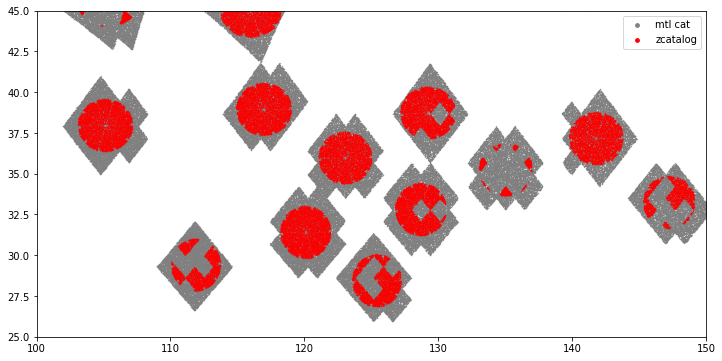

In [89]:
plt.figure(figsize=(12,6))
plt.scatter(mtl['RA'][::10], mtl['DEC'][::10], s=0.08, c='gray', label='mtl cat')
plt.scatter(zcat['RA'], zcat['DEC'], s=0.1, c='r', label='zcatalog')
plt.legend()
plt.xlim(100, 150)
plt.ylim(25, 45)

lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([14.0])

# BGS SV bits

define the BGS SV data sets...

In [160]:
bgs_bright = (np.uint64(zcat['SV1_BGS_TARGET']) & np.uint64(bgs_mask['BGS_BRIGHT']))!=0
bgs_faint = (np.uint64(zcat['SV1_BGS_TARGET']) & np.uint64(bgs_mask['BGS_FAINT']))!=0
bgs_faint_ext = (np.uint64(zcat['SV1_BGS_TARGET']) & np.uint64(bgs_mask['BGS_FAINT_EXT']))!=0
bgs_lowq = (np.uint64(zcat['SV1_BGS_TARGET']) & np.uint64(bgs_mask['BGS_LOWQ']))!=0
bgs_fibmag = (np.uint64(zcat['SV1_BGS_TARGET']) & np.uint64(bgs_mask['BGS_FIBMAG']))!=0

bgs_nominal = (bgs_bright) | (bgs_faint)

In [148]:
bgsBits = {'bright':bgs_bright, 'faint':bgs_faint, 'faint_ext':bgs_faint_ext, 'lowq':bgs_lowq, 'fibmag':bgs_fibmag}
for i in bgsBits:
    print('# BGS %s targeted: %i' %(i, np.sum(bgsBits[i])))

# BGS bright targeted: 56662
# BGS faint targeted: 7637
# BGS faint_ext targeted: 1779
# BGS lowq targeted: 0
# BGS fibmag targeted: 243


## TILE cloose up for BGS SV

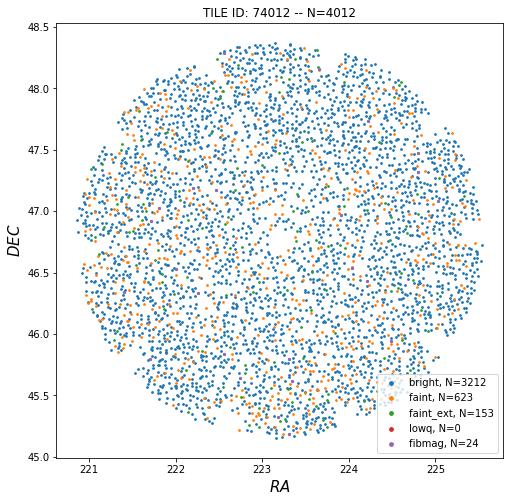

In [156]:
#find all tiles in the BRIGHT program and choose one...
N=3
tile_bgs_idx = list(np.where(tiles['PROGRAM'] == b'BRIGHT'))[0][N]
RAc, DECc = tiles['RA'][tile_bgs_idx], tiles['DEC'][tile_bgs_idx]
tileBox = (zcat['RA'] < RAc+2.5) & (zcat['RA'] > RAc-2.5) & (zcat['DEC'] < DECc+2.5) & (zcat['DEC'] > DECc-2.5)

plt.figure(figsize=(8,8))

j = 0.
for i in bgsBits:
    tileMask = (bgsBits[i]) & (tileBox)
    j += np.sum(tileMask)
    if np.sum(tileMask) < 100:
        s1 = 5
    else:
        s1 = 3
    plt.scatter(zcat['RA'][tileMask], zcat['DEC'][tileMask], s=s1, label='%s, N=%i' %(i, np.sum(tileMask)))

plt.title('TILE ID: %i -- N=%i' %(tiles['TILEID'][tile_bgs_idx], j))
plt.xlabel(r'$RA$', size=15)
plt.ylabel(r'$DEC$', size=15)
plt.legend()
lgnd = plt.legend()
for handle in lgnd.legendHandles:
    handle.set_sizes([14.0])

## Total mag Vs FIBRE mag (r-band)

Below some examples of total Vs Fibre mags in r-band. The plots are 2D where hexbins can be any array asociated with the `zcatalog`. In the examples below, colours are number counts in first plot and redshift in the second one, both use the BGS BRIGHT bit.

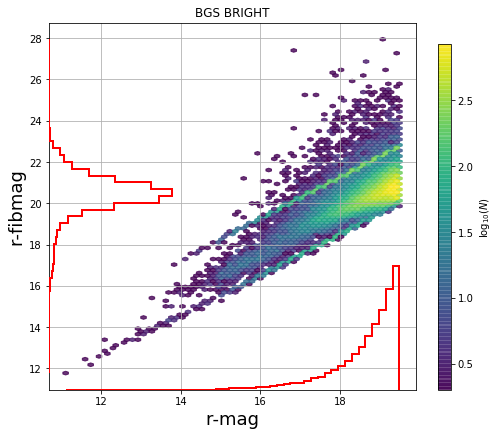

In [212]:
rmag_fibmag_density(zcat[bgs_bright], 'BGS BRIGHT', otherCat=False, MASK=None, Cpar=None, CparName=None, log=True)

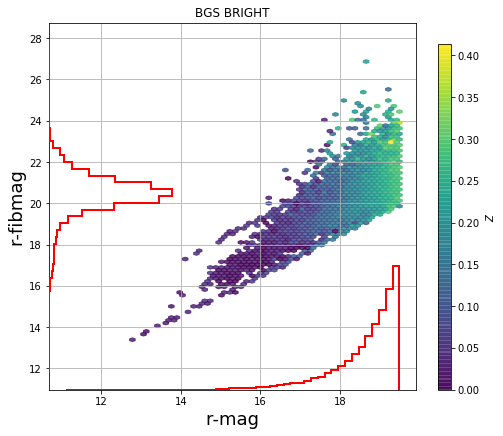

In [213]:
rmag_fibmag_density(zcat[bgs_bright], 'BGS BRIGHT', otherCat=False, MASK=None, Cpar=zcat['Z'][bgs_bright], CparName='Z', log=False)

## Colour-colour plots: g-r Vs r-z

Below some examples of g-r Vs r-z colour-colour 2D plots. Same as above example, the hexbins can be any array asociated with the `zcatalog`. In the examples below, colours are number counts in first plot and redshift in the second one, both use the BGS BRIGHT bit.

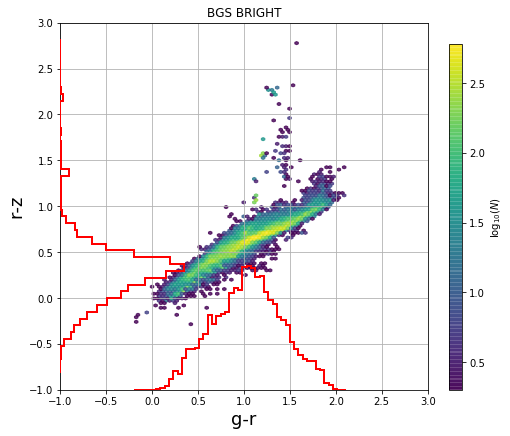

In [215]:
gr_rz_density(zcat[bgs_bright], 'BGS BRIGHT', fixed=True, otherCat=False, MASK=None, Cpar=None, CparName=None, log=True)

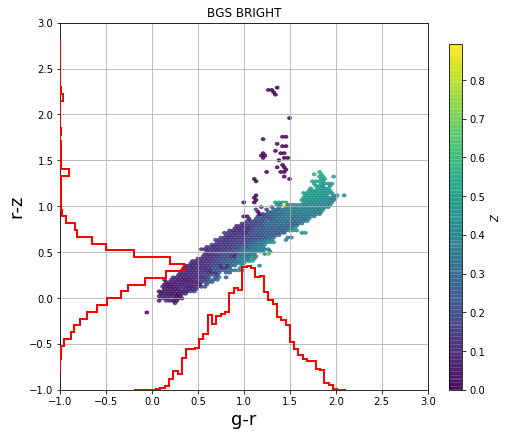

In [218]:
gr_rz_density(zcat[bgs_bright], 'BGS BRIGHT', fixed=True, otherCat=False,  Cpar=zcat['Z'][bgs_bright], CparName='Z', log=False)

# DEFINITIONS...

## Get density of irregular patches with 2D-histograms...

In [181]:
def density_patch(cat1, nbins=100, sigma=False, plot=False):
    from matplotlib.colors import LogNorm
    
    bins = np.linspace(-1, 3, nbins)
    bin_spacing = bins[1] - bins[0]
    bincenter = (bins[1:]+bins[:-1])/2
    #mesh_x, mesh_y = np.meshgrid(bincenter, bincenter)
    
    rmag = flux_to_mag(cat1['FLUX_R']/cat1['MW_TRANSMISSION_R'])
    gmag = flux_to_mag(cat1['FLUX_G']/cat1['MW_TRANSMISSION_G'])
    zmag = flux_to_mag(cat1['FLUX_Z']/cat1['MW_TRANSMISSION_Z'])
    
    mask = (~np.isnan(gmag)) & (~np.isnan(zmag)) & (~np.isinf(gmag)) & (~np.isinf(zmag)) 
    rmag = rmag[mask]
    gmag = gmag[mask]
    zmag = zmag[mask]
    xx, yy = gmag - rmag, rmag - zmag
    
    #taking the 2d histogram and divide by the area of each bin to get the density
    density, _, _ = np.histogram2d(xx, yy, bins=bins)
    if sigma:
        density[density < 50] = np.nan
    
    if plot:
        plt.figure(figsize=(8, 8))
        plt.imshow(density.transpose(), origin='lower', aspect='equal',
               cmap='seismic', extent=np.array([-1, 3, -1, 3]), norm=LogNorm()) #, vmin=-3, vmax=3
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.grid()
        plt.xlabel('g-r')
        plt.ylabel('r-z')
    
    return density


In [182]:
def plot_test(den1, den2, plot=False):
    
    density = den1.copy()
    density2 = den2.copy()
    
    density[(density2 < 1) | (np.isnan(density2))] = 0
    
    tot = np.sum(density)
    print('Total objects in locus: %i' %(tot))
    
    if plot:
        from matplotlib.colors import LogNorm
        plt.figure(figsize=(8, 8))
        plt.imshow(density.transpose(), origin='lower', aspect='equal',
               cmap='seismic', extent=np.array([-1, 3, -1, 3]), norm=LogNorm())
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.grid()
    
    return tot
    

In [204]:
def rmag_fibmag_density(cat1, title, otherCat=False, MASK=None, Cpar=None, CparName=None, log=False):
    
    rmag = flux_to_mag(cat1['FLUX_R']/cat1['MW_TRANSMISSION_R'])
    gmag = flux_to_mag(cat1['FLUX_G']/cat1['MW_TRANSMISSION_G'])
    zmag = flux_to_mag(cat1['FLUX_Z']/cat1['MW_TRANSMISSION_Z'])
    fibmag = flux_to_mag(cat1['FIBERFLUX_R']/cat1['MW_TRANSMISSION_R'])
    
    mask = (~np.isnan(gmag)) & (~np.isnan(zmag)) & (~np.isinf(gmag)) & (~np.isinf(zmag))
    rmag = rmag[mask]
    gmag = gmag[mask]
    zmag = zmag[mask]
    fibmag = fibmag[mask]
    
    fig = plt.figure(figsize=(6, 6))
    
    left, width = 0.1, 0.85
    bottom, height = 0.1, 0.85

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom, width, 0.3]
    rect_histy = [left, bottom, 0.3, height]
    colbar = [1.1, 0.1, 0.1, 0.85]

    axScatter = plt.axes(rect_scatter)
    axScatter.set_title(title)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    x = rmag
    y = fibmag
    
    if log:
        bins1 = 'log'
    else:
        bins1 = None
        
    pos = axScatter.hexbin(x, y, C=Cpar, gridsize=(60,60), cmap='viridis', bins=bins1, 
                           mincnt=1,label=r'test', alpha=0.8)
 
    cbaxes = fig.add_axes([1, 0.1, 0.03, 0.8])
    
    if Cpar is None:
        CparName = 'N'
        
    if log:
        fig.colorbar(pos, cax=cbaxes, label=r'$\log_{10}(%s)$' %(CparName))
    else:
        fig.colorbar(pos, cax=cbaxes, label=r'$%s$' %(CparName))
        
    axScatter.set_xlabel(r'r-mag', size=18)
    axScatter.set_ylabel(r'r-fibmag', size=18)
    axScatter.grid()
    
    binsy = np.linspace(y.min(), y.max(), 50)
    binsx = np.linspace(x.min(), x.max(), 50)
    
    N1 = axHistx.hist(x, bins=binsx, cumulative=False, log=False, histtype='step', align='mid', color='r', linewidth=2)
    N2 = axHisty.hist(y, bins=binsy, cumulative=False, log=False, histtype='step', align='mid', color='r', linewidth=2, orientation='horizontal')
    
    axHistx.axis('off')
    axHisty.axis('off')
   

In [214]:
def gr_rz_density(cat1, title, fixed=False, otherCat=False, MASK=None, Cpar=None, CparName=None, log=False):
    
    rmag = flux_to_mag(cat1['FLUX_R']/cat1['MW_TRANSMISSION_R'])
    gmag = flux_to_mag(cat1['FLUX_G']/cat1['MW_TRANSMISSION_G'])
    zmag = flux_to_mag(cat1['FLUX_Z']/cat1['MW_TRANSMISSION_Z'])
    
    mask = (~np.isnan(gmag)) & (~np.isnan(zmag)) & (~np.isinf(gmag)) & (~np.isinf(zmag))
    rmag = rmag[mask]
    gmag = gmag[mask]
    zmag = zmag[mask]
    
    fig = plt.figure(figsize=(6, 6))
    
    left, width = 0.1, 0.85
    bottom, height = 0.1, 0.85

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom, width, 0.3]
    rect_histy = [left, bottom, 0.3, height]
    colbar = [1.1, 0.1, 0.1, 0.85]

    axScatter = plt.axes(rect_scatter)
    axScatter.set_title(title)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    if log:
        bins1 = 'log'
    else:
        bins1 = None
        
    pos = axScatter.hexbin(gmag-rmag, rmag-zmag, C=Cpar, gridsize=(60,60), cmap='viridis', bins=bins1, 
                           mincnt=1,label=r'test', alpha=0.8)
 
    cbaxes = fig.add_axes([1, 0.1, 0.03, 0.8])
    
    if Cpar is None:
        CparName = 'N'
        
    if log:
        fig.colorbar(pos, cax=cbaxes, label=r'$\log_{10}(%s)$' %(CparName))
    else:
        fig.colorbar(pos, cax=cbaxes, label=r'$%s$' %(CparName))

    axScatter.set_ylabel(r'r-z', size=18)
    axScatter.set_xlabel(r'g-r', size=18)
    axScatter.grid()
    
    gr = gmag-rmag
    rz = rmag-zmag
    binsy = np.linspace(rz.min(), rz.max(), 50)
    binsx = np.linspace(gr.min(), gr.max(), 50)
    
    N1 = axHistx.hist(gr, bins=binsx, cumulative=False, log=False, histtype='step', align='mid', color='r', linewidth=2)
    N2 = axHisty.hist(rz, bins=binsy, cumulative=False, log=False, histtype='step', align='mid', color='r', linewidth=2, orientation='horizontal')
        
    if fixed:
        
        axScatter.set_xlim(-1, 3)
        #axScatter.set_ylim(0.5, 2)
        axScatter.set_ylim(-1, 3)
        
        axHistx.set_xlim(-1, 3)
        #axHisty.set_ylim(0.5, 2)
        axScatter.set_ylim(-1, 3)
    
    axHistx.axis('off')
    axHisty.axis('off')
   

In [179]:
def search_around(ra1, dec1, ra2, dec2, search_radius=1., verbose=True):
    '''
    Using the astropy.coordinates.search_around_sky module to find all pairs within
    some search radius.
    Inputs:
    RA and Dec of two catalogs;
    search_radius (arcsec);
    Outputs:
        idx1, idx2: indices of matched objects in the two catalogs;
        d2d: angular distances (arcsec);
        d_ra, d_dec: the differences in RA and Dec (arcsec);
    '''

    # protect the global variables from being changed by np.sort
    ra1, dec1, ra2, dec2 = map(np.copy, [ra1, dec1, ra2, dec2])

    # Matching catalogs
    sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
    sky2 = SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')
    idx1, idx2, d2d, d3d = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
    if verbose:
        print('%d nearby objects ~ %g %%'%(len(idx1), 100*len(idx1)/len(ra2)))

    # convert distances to numpy array in arcsec
    d2d = np.array(d2d.to(u.arcsec))


    d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
    d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
    ##### Convert d_ra to actual arcsecs #####
    mask = d_ra > 180*3600
    d_ra[mask] = d_ra[mask] - 360.*3600
    mask = d_ra < -180*3600
    d_ra[mask] = d_ra[mask] + 360.*3600
    d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)
    ##########################################

    return idx1, idx2, d2d, d_ra, d_dec